# Lab Two: Exploring Image Data

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Business Understanding](#business_understanding)<br>
 2. [Data Preparation](#data_prep)<br>
  2.1 [Read In Images](#read_images)<br>
  2.2 [Linearize the Images](#linearize)<br>
  2.3 [Visualize Images](#visualize)<br>
 3. [Data Reduction](#data_reduction)<br>
  3.1 [Linear Dimensionality Reduction](#linear_dim_reduc)<br>
  3.2 [Non-Linear Dimensionality Reduction](#non_linear_dim_reduc)<br>
  3.3 [Compare Representations](#compare_representations)<br>
  ... 3.3.1 [By Eye](#eye)<br>
  ... 3.3.2 [Mean Squared Error](#mse)<br>
  ... 3.3.3 [Normalized Mean Squared Error](#nrmse)<br>
  ... 3.3.4 [Peak Signal to Noise Ratio](#psnr)<br>
  ... 3.3.5 [Structural Similarity Index](#ssim)<br>
  ... 3.3.6 [L$_P$ Norm](#lp)<br>
  3.4 [Feature Extraction](#feature_extraction)<br>
  ... 3.4.1 [Gabor Filters](#gabor)<br>
  ... 3.4.2 [Daisy](#daisy)<br>
  ... 3.4.3 [Fast Fourier Transfrom](#fft)<br>
  3.5 [Prediction Promise](#prediction_promise)<br>
 4. [Exceptional Work](#exceptional_work")<br>
  4.1 [ORB](#orb)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (Is this really the best way to comment)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

## Business Understanding
<a id="business_understanding"></a>

> __[20 points]__ Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data.

For this project we chose to use a [random sample of NIH Chest X-Ray Dataset](https://www.kaggle.com/nih-chest-xrays/sample/home). This dataset contains 5606 images that have been preprocessed to be a uniform size of $1024 \times 1024$ and also includes a csv containing the labels associated with the x-ray images.

Chest X-rays are one of the most cost-efficient methods used to evaluate the lungs, heart, and chest wall. Chest X-rays are often used in emergency diagnosis because they are fast and easy. These X-rays may be used to help diagnose persistant coughs, chest pain, fever, shortness of breath, as well as many other ailments. However, chest X-rays do not provide the level of detail that full CT scans do, albeit at an increased dose of radiation. 

Computer-aided detection and diagnosis is one technique to help alleviate this deficiency in X-rays compared to full CT scans. In order to implement computer-aided detection and diagnosis in real world medical sites, it is necessary to have large, publically available image datasets with annotations. The full NIH dataset, which contains 112,120 X-ray images, was released to fill this void. It should be noted that the labels were generated using natural language processing and are therefore not 100% accurate. It is estimated by the [original authors](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) that the labels are >90% accurate though. As an aside, their method for generating th labels is fascinating in its own right.

Our task to to use the images to predict the diagnoses in the included labels. Since the kaggle subset of the data has already been preprocessed some, we will not have to do much here. If we decide to look at the full dataset later, we will need to make sure all of the images are the same size and may need to re-orient some of them. These results would likely be interesting to small to medium sized health care facilities that have access to X-ray machines but don't have access to CT or MRI scanners. The results may also be interesting to larger facilites that do have access to the more expensive machinery if it can be shown that the same level of patient care can be delivered at a smaller cost using X-rays and computer-aided detection and diagnosis.

Experts at Stanford have also analyzed this dataset using a [121-layer convolutional neural network](https://arxiv.org/pdf/1711.05225.pdf). The CNN was able to acheive a F1 score ([wiki](https://en.wikipedia.org/wiki/F1_score), [toward data science](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)) of 0.435 (95% CI). This is perhaps an interesting metric we can use that accounts for false positives and false negatives. It is implemented as sklearn.metrics.f1_score. The set of radiologists that also analyzed the images for the Stanford study achieved an average F1 score of 0.387.

## Data Preparation
<a id="data_prep"></a>

> $\cdot$ __[5 points]__ Read in your images as numpy arrays. Resize and recolor images as necessary. <br>
 $\cdot$ __[4 points]__ Linearize the images to create a table of 1-D images features (each row should be one image).<br>
 $\cdot$ __[1 point]__ Visualize several images.

### Read In Images, Resize and recolor as necessary.
<a id="read_images"></a>

We chose to resize the images using [Pillow](https://python-pillow.org/) because there is no need to rewrite code that someone else has already written. It should also be noted that there are many methods that can be used to resize the images, but for our purposes using ```img.thumbnail(size)``` was the most simple. We also show a sample method that allows us to explicitely control the parameters. We chose to resize the images to $256 \times 256$. This allows us to process the images in a reasonable time while also preserving most of the characterisics of the original images.

Also, we decided to only analyze the males who were imaged from posterior from anterior. This minimized the possible variations in images so that we are only styding how the images change with various diseases, atleast as much as possible.

In [257]:
# first resize the images
import os
from PIL import Image
import time
from IPython.display import display, clear_output

base = os.getcwd()
full = os.path.join(base,'images/full_size/images/')
basesize = 512
t_start = time.time()
i=0

t_size = 64,64
for (dirpath, dirnames, filenames) in os.walk(full):
    # this one is quicker to run, but we lose some of the control
    for file in filenames:
        img = Image.open(os.path.join(full+file)).convert('L')
        img.thumbnail(t_size)
        img.save(os.path.join(base,'images/resize/test/',file))
        i+=1
        if i%100 == 0:
            print('finished #{}: {}: finial dimensions ({} {}): time so far {:.2f} seconds'.format(i, file, img.size[0], img.size[1], time.time()-t_start))


# for (dirpath, dirnames, filenames) in os.walk(full):
#     for file in filenames:
#         img = Image.open(os.path.join(full+file)).convert('L') # convert because a few of the images are rgb
#         wpercent = (basesize / float(img.size[0]))
#         hsize = int((float(img.size[1]) * float(wpercent)))
#         color_thumb = img.resize((basesize, hsize), Image.ANTIALIAS)
#         #img.save(os.path.join(base,'images/resize/color/',file))
#         # should not need to crop, but just in case
#         crop_top = hsize - basesize
#         crop_image = color_thumb.crop((0, crop_top, basesize, hsize))
#         crop_image.save(os.path.join(base,'images/resize/crop/',file)) # I should probably be using scratch space...
#         print('finished #{}: {}: Original Dimensions ({} {}) : finial dimensions ({} {}): time so far {:.2f} seconds'.format(i, file, img.size[0], img.size[1], crop_image.size[0], crop_image.size[1], time.time()-t_start))
#         i+=1
#         if i%10==0:
#             clear_output() # clear the output every 10 images


finished #100: 00000554_000.png: finial dimensions (64 64): time so far 1.86 seconds
finished #200: 00001101_018.png: finial dimensions (64 64): time so far 5.14 seconds
finished #300: 00001589_001.png: finial dimensions (64 64): time so far 8.76 seconds
finished #400: 00002058_032.png: finial dimensions (64 64): time so far 12.15 seconds
finished #500: 00002597_000.png: finial dimensions (64 64): time so far 16.00 seconds
finished #600: 00003079_000.png: finial dimensions (64 64): time so far 18.21 seconds
finished #700: 00003635_004.png: finial dimensions (64 64): time so far 20.18 seconds
finished #800: 00004163_006.png: finial dimensions (64 64): time so far 22.17 seconds
finished #900: 00004795_000.png: finial dimensions (64 64): time so far 24.08 seconds
finished #1000: 00005218_020.png: finial dimensions (64 64): time so far 26.25 seconds
finished #1100: 00005742_009.png: finial dimensions (64 64): time so far 30.56 seconds
finished #1200: 00006329_014.png: finial dimensions (64

Now read in the resized images as np arrays, linearize them, and create a table of 1-D image features.
<a id="linearize"></a>

In [1]:
# first make new dataframes and save as csvs
import pandas as pd
import numpy as np

aux_df = pd.read_csv('sample_labels.csv')
gen_df = aux_df[aux_df['Patient Gender'] == 'M']
gen_df_AP = gen_df[gen_df['View Position'] == 'AP']
gen_df_PA = gen_df[gen_df['View Position'] == 'PA']

print('Male and AP', gen_df_AP.shape)
print('Male and PA', gen_df_PA.shape)

aux_df.to_csv('male_df.csv')
gen_df_AP.to_csv('male_AP_df.csv')
gen_df_PA.to_csv('male_PA_df.csv')

#gen_df_PA

Male and AP (1290, 11)
Male and PA (1844, 11)


In [12]:
# now loop over the male PA, linearize the data, save to new CSV 

import pandas as pd
import csv
import matplotlib.image as mpimg # this reads as np arrays (also other choices I am sure)
import time

base = os.getcwd()

t_start = time.time()
counter = 0
with open('male_PA_vectorized.csv','w+') as f:
    #writer = csv.writer(f)
    for imgname in gen_df_PA['Image Index']:
        if counter % 100 == 0:
            gb = os.path.getsize('male_PA_vectorized.csv') * 1e-9
            print('now working on {}: # {}: {:.2f} s: filesize {:.4f} GB'.format(imgname, counter, time.time()-t_start, gb))
        img_path = os.path.join(base,'images/resize/thumb',imgname)
        img_mpl = mpimg.imread(img_path)
        lst = np.reshape(img_mpl,(1,np.product(img_mpl.shape)))[0].tolist()
        lst = ['{:.5f}'.format(x) for x in lst]
        lst.insert(0,imgname)
        f.write(', '.join(map(str, lst)))
        #writer.writerow(lst)
        counter += 1

now working on 00000030_001.png: # 0: 0.00 s: filesize 0.0000 GB
now working on 00001816_001.png: # 100: 3.10 s: filesize 0.0590 GB
now working on 00003426_029.png: # 200: 6.17 s: filesize 0.1180 GB
now working on 00005119_002.png: # 300: 9.26 s: filesize 0.1770 GB
now working on 00006942_000.png: # 400: 12.34 s: filesize 0.2359 GB
now working on 00008866_005.png: # 500: 15.43 s: filesize 0.2949 GB
now working on 00010512_001.png: # 600: 18.52 s: filesize 0.3539 GB
now working on 00011771_002.png: # 700: 21.61 s: filesize 0.4129 GB
now working on 00013131_000.png: # 800: 24.68 s: filesize 0.4719 GB
now working on 00014452_013.png: # 900: 27.77 s: filesize 0.5309 GB
now working on 00016134_017.png: # 1000: 30.85 s: filesize 0.5898 GB
now working on 00017618_019.png: # 1100: 33.94 s: filesize 0.6488 GB
now working on 00018860_023.png: # 1200: 37.01 s: filesize 0.7078 GB
now working on 00020209_005.png: # 1300: 40.13 s: filesize 0.7668 GB
now working on 00021796_011.png: # 1400: 43.19 s: 

In [258]:
# we saved a .csv, but appearantly we can not load it without getting memory errors, so make the dataframe directly
# possibly quicker to make a list of lists so that we don't have to copy each time?
import matplotlib.image as mpimg
import os
import time

base = os.getcwd()
dir_path = os.path.join(base,'images/resize/thumb/')
img_names = gen_df_PA['Image Index'].tolist()

img = img_names[0]
img_path = os.path.join(dir_path,img)
img_mpl = mpimg.imread(img_path)
reshape = np.reshape(img_mpl,(1,-1))
vector_df = pd.DataFrame(reshape)
vector_df.insert(0,column='Image_Index',value=img)

counter = 1
t_start = time.time()
for img in img_names[1:]:
    img_path = os.path.join(dir_path,img)
    img_mpl = mpimg.imread(img_path)
    reshape = np.reshape(img_mpl,(1,-1))
    temp_df = pd.DataFrame(reshape)
    temp_df.insert(0,column='Image_Index',value=img)
    vector_df = vector_df.append(temp_df, ignore_index=True) # see comment above...
    if counter%100==0:
        print('finished working on {} after {:.1f} seconds'.format(counter, time.time()-t_start))
    counter += 1

finished working on 100 after 1.7 seconds
finished working on 200 after 4.3 seconds
finished working on 300 after 8.4 seconds
finished working on 400 after 13.5 seconds
finished working on 500 after 19.7 seconds
finished working on 600 after 27.5 seconds
finished working on 700 after 36.8 seconds
finished working on 800 after 46.4 seconds
finished working on 900 after 57.0 seconds
finished working on 1000 after 68.7 seconds
finished working on 1100 after 81.3 seconds
finished working on 1200 after 94.6 seconds
finished working on 1300 after 109.1 seconds
finished working on 1400 after 124.5 seconds
finished working on 1500 after 141.4 seconds
finished working on 1600 after 159.5 seconds
finished working on 1700 after 178.2 seconds
finished working on 1800 after 197.3 seconds


In [5]:
print('total memory used {:.3f} GB'.format(vector_df.memory_usage(index=True).sum()*1e-9))

total memory used 0.483 GB


For the time being, we will drop the patients with more than one disease. This leaves us with a total of 1562 images to classify. In the future we may want to study the effects of multiple diseases on our results.

In [6]:
# get a baseline

single_disease = 0
multiple_disease = 0
classes = 0
for val, grp in gen_df_PA.groupby(by='Finding Labels'):
    #print(val, len(grp))
    if '|' in val:
        multiple_disease += len(grp)
    else:
        single_disease += len(grp)
        classes += 1
print('single disease total {}'.format(single_disease))
print('multiple disease total {}'.format(multiple_disease))
print('number of single disease (plus no finding) {}'.format(classes))

single disease total 1562
multiple disease total 282
number of single disease (plus no finding) 15


In [254]:
# now drop
gen_df_PA_single = gen_df_PA[~gen_df_PA['Finding Labels'].str.contains('|', regex=False)]

single_disease = 0
multiple_disease = 0
classes = 0

for val, grp in gen_df_PA_single.groupby(by='Finding Labels'):
    #print(val, len(grp))
    if '|' in val:
        multiple_disease += len(grp)
    else:
        single_disease += len(grp)
        classes += 1
print('single disease total {}'.format(single_disease))
print('multiple disease total {}'.format(multiple_disease))
print('number of single disease (plus no finding) {}'.format(classes))
print('shape of single diseases df {}'.format(gen_df_PA_single.shape))

# and save to csv and hope we can read it in
gen_df_PA_single.to_csv('male_PA_single_disease.csv', index=False)

single disease total 1562
multiple disease total 0
number of single disease (plus no finding) 15
shape of single diseases df (1562, 11)


Now we can visualize several images, I will use matplotlib because it allows easy control of subplots.
<a id="visualize"></a>

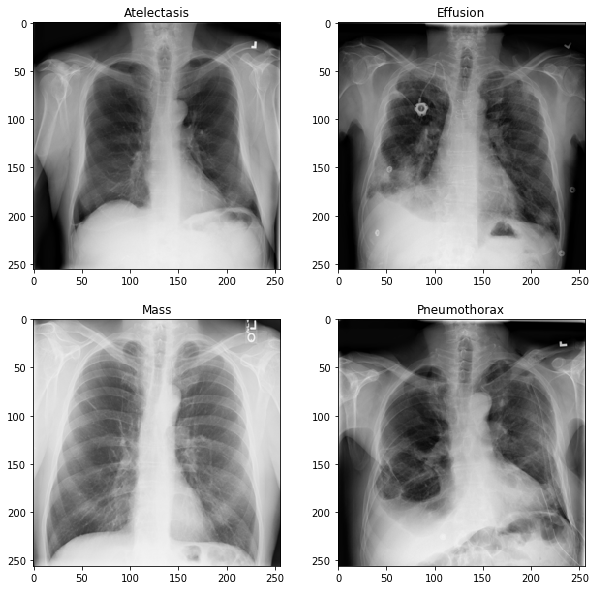

In [88]:
import matplotlib.pyplot as plt
from PIL import Image

indices = [0,1,2,3]
base = os.getcwd()
path = os.path.join(base,'images/resize/thumb/')

fig = plt.figure(figsize = (10,10))
for indx in range(len(indices)):

    ax = fig.add_subplot(2,2,indx+1)
    name = gen_df_PA_single['Image Index'].iloc[indx]
    finding = gen_df_PA_single['Finding Labels'].iloc[indx]
    full = os.path.join(path,name)
    img = Image.open(full)
    ax.imshow(img)
    ax.set_title(finding)
    
plt.show()

## Data Reduction (__60 points total__)
<a id="data_reduction"></a>

> $\cdot$ __[5 points]__ Perform __linear__ dimensionality reduction of the images using principal components analysis. Visualize.<br>
$\cdot$ __[5 points]__ Perform __non-linear__ dimensionality reduction of your image data.<br>
$\cdot$ __[20 points]__ Compare teh representations using non-linear dimensions to using linear dimensions. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components. Be aware that mean-squared error may not be a good measurement for kPCA. Do you prefer another method over another? Why?<br>
$\cdot$ __[10 points]__ Perform __feature extraction__ upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).<br>
$\cdot$ __[20 points]__ Does this feature extraction method show promise for your prediction tak? Why? Use visualizations to analyze this question. For example, visualize the differences __between statistics of the extracted features__ in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.<br>

### Linear dimensionality reduction
<a id="linear_dim_reduc"></a>



In [10]:
# first, linear dimensionality reduction using PCA
from sklearn.decomposition import PCA

t_start = time.time()

dat = vector_df[list(vector_df)[1:]]

print(dat.shape[1])

pca = PCA(n_components = dat.shape[1])
pca.fit(dat.copy())
print('finished in {:.2f}'.format((time.time()-t_start)/60))

65536
finished in 0.70


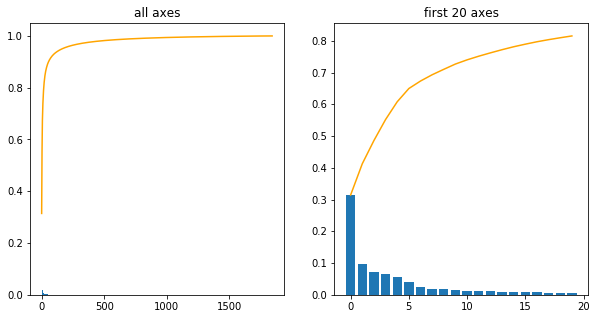

In [11]:
# the explained variances (eigenvalues associated with each eigenvector normalized to sum of all eigen vectors)

import matplotlib.pyplot as plt

explained_var = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(explained_var)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('all axes')
ax.bar(np.arange(0,len(explained_var)),explained_var)
ax.plot(cum_var_exp, color='orange')
ax1 = fig.add_subplot(1,2,2)
ax1.set_title('first 20 axes')
ax1.bar(np.arange(0,20),explained_var[:20])
ax1.plot(cum_var_exp[:20], color='orange')
plt.show()

In [12]:
# now for some thresholds

thresholds = [0.7,0.8,0.9,0.95,0.99]
n_axes = []
for t in thresholds:
    index = [n for n,i in enumerate(cum_var_exp) if i > t][0] # possibly a faster way to do this using np, but this works
    n_axes.append(index+1)
    print('for a threshold of {}, we would need {} axes'.format(t,index+1))

for a threshold of 0.7, we would need 9 axes
for a threshold of 0.8, we would need 18 axes
for a threshold of 0.9, we would need 56 axes
for a threshold of 0.95, we would need 164 axes
for a threshold of 0.99, we would need 764 axes


Above we can see that it is not necessary to keep all of the axes to explain most of the variance. On modern machines, 452 axes should be managable. This also captures 99% of the explained variance which will hopefully be enough for what we want to do.

In [89]:
def reconstruct_image(trans_obj,org_features):
    '''
    This is exactly from 
    https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
    '''
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

In [15]:
h = 256
w = 256

t_start = time.time()

combined_low_dim_reps = []
for n_ax in n_axes:
    pca = PCA(n_components = int(n_ax))
    pca.fit(dat.copy())
    print('finished PCA with {} axes in {:.2f} seconds'.format(n_ax, time.time()-t_start))
    
    low_dim_images = []
    for idx_to_reconstruct in indices:
        X_idx = dat.iloc[idx_to_reconstruct]
        low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.values.reshape(1, -1))
        low_dim_images.append(reconstructed_image)
    combined_low_dim_reps.append(low_dim_images)


print(len(combined_low_dim_reps))
print(len(combined_low_dim_reps[0]))

finished PCA with 9 axes in 3.18 seconds


/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


finished PCA with 18 axes in 6.35 seconds
finished PCA with 56 axes in 11.39 seconds
finished PCA with 164 axes in 18.34 seconds
finished PCA with 764 axes in 43.82 seconds
5
4


n_rows 5, n_cols 4


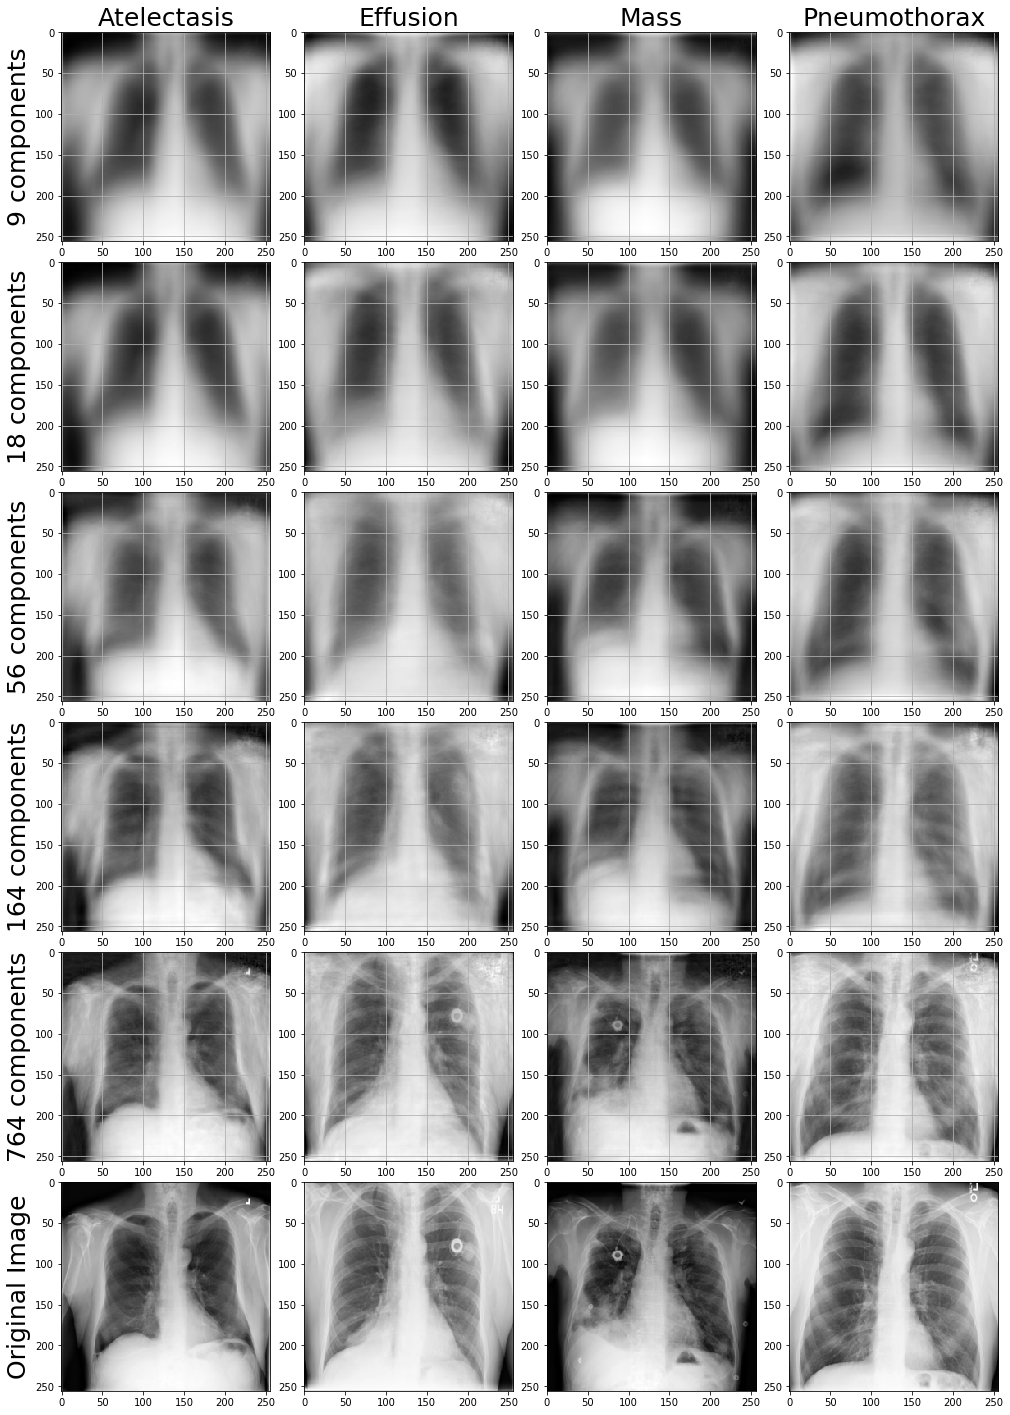

In [33]:

fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
n_rows = len(n_axes)
print('n_rows {}, n_cols {}'.format(n_rows,n_cols))
for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        if row_num == 0:
            ax.set_title('{}'.format(findings[col_num]), fontsize=25)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()


As we can see from the images above, reducing the number of dimensions that the information is projected into using linear PCA affects all of the original images roughly equally. Projecting the original images into 764 axes (99% of the explained variance) then reconstructing yeilds images that are recognizable, and may contain enought detail for a doctor to find useful. Projecting the original image into 164 axes (90% of the explained variance) leaves the reconstructed image recognizable, but not likely useful for a doctor. Projecting into fewer axes leaves the reconstructed images barely recognizable and not likley useful for a doctor. Maybe machine learning techniques can still find useful information in the reduced quality images, but a doctor probably can not.

It should also be noted that the linear PCA ran in a reasonable time so it would likely be possible to include more axes if necessary. We will not so that we can compare to kPCA.

### Non-Linear dimensionality reduction
<a id="non_linear_dim_reduc"></a>



In [21]:
# now basically do the same thing with kernal PCA
from sklearn.decomposition import KernelPCA

h = 256
w = 256

t_start = time.time()

kpca_combined_low_dim_reps = []
for n_ax in n_axes:
    kpca = KernelPCA(n_components = int(n_ax), kernel='rbf',
              fit_inverse_transform=True, gamma=12,
              remove_zero_eig=True)
    kpca.fit(dat.copy())
    print('finished building kPCA with {} axes in {:.2f} seconds'.format(n_ax, time.time()-t_start))
    
    low_dim_images = []
    for idx_to_reconstruct in indices:
        X_idx = dat.iloc[idx_to_reconstruct]
        low_dimensional_representation, reconstructed_image = reconstruct_image(kpca,X_idx.values.reshape(1, -1))
        low_dim_images.append(reconstructed_image)
    kpca_combined_low_dim_reps.append(low_dim_images)
    print('finished imaging kPCA with {} axes in {:.2f} seconds'.format(n_ax, time.time()-t_start))


print(len(kpca_combined_low_dim_reps))
print(len(kpca_combined_low_dim_reps[0]))

finished building kPCA with 9 axes in 391.04 seconds


/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


finished imaging kPCA with 9 axes in 391.95 seconds
finished building kPCA with 18 axes in 786.50 seconds
finished imaging kPCA with 18 axes in 787.37 seconds
finished building kPCA with 56 axes in 1176.03 seconds
finished imaging kPCA with 56 axes in 1176.91 seconds
finished building kPCA with 164 axes in 1577.51 seconds
finished imaging kPCA with 164 axes in 1578.40 seconds
finished building kPCA with 764 axes in 2075.12 seconds
finished imaging kPCA with 764 axes in 2076.03 seconds
5
4


n_rows 5, n_cols 4


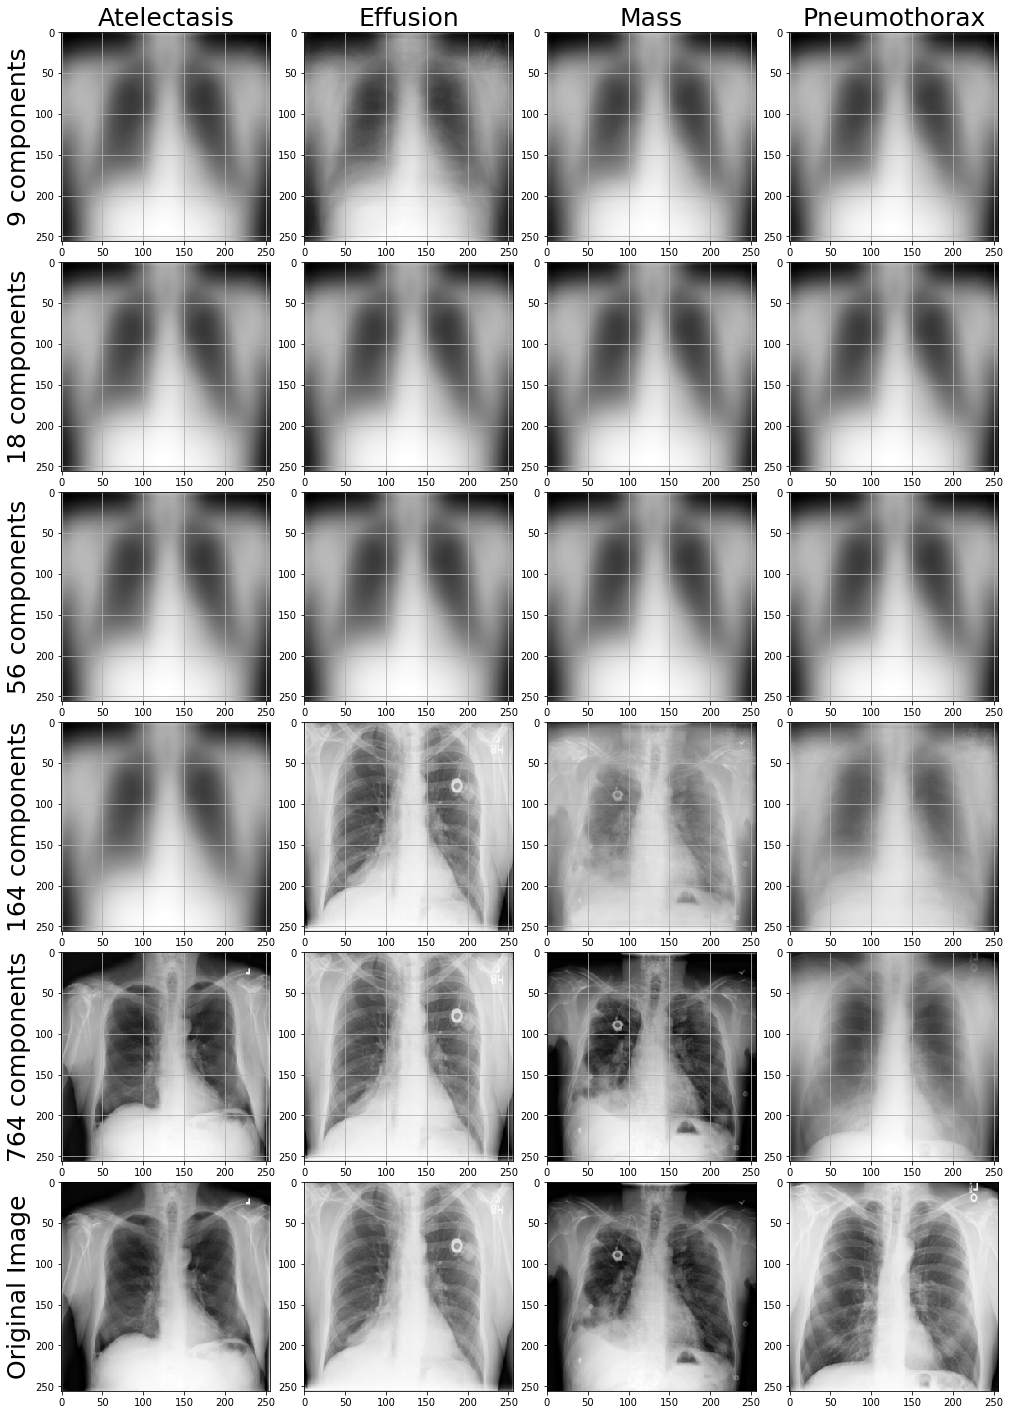

In [34]:
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
n_rows = len(n_axes)
print('n_rows {}, n_cols {}'.format(n_rows,n_cols))
for row_num in range(n_rows):
    low_dim_representation = kpca_combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        if row_num == 0:
            ax.set_title('{}'.format(findings[col_num]), fontsize=25)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()


We can see in the images above that kernal PCA does not affect all images equally. Some of the images, specifically the image for Effusion, were able to be reconstructed in a usable manner using fewer axes. However, some images, specifically the image for Pneumothorax were hardly recognizable, even using 764 components. Other kernels or different parameters may lead to better performance, but based off of this it is hard to recommend using kernal PCA for this dataset. It appears to be too unpredictable in its performance (atleast in terms of the reconstructed image).

It takes several minutes to fit the data using kPCA. Because of this, we will not attempt to include more axes.

### Compare Representations
<a id="compare_representations"></a>

There are many methods that can be use to calculate the closeness of two images. We will go over a few of the most common methods (which conveniently are include in skimage.measure).

#### By Eye
<a id="eye"></a>

Before we do any quantitative comparisons between the various representations, let us take a look at the reconstructed images from a single original x-ray. This will give us an idea of how well a doctor would likely be able to diagnose based off the reconstructed images.

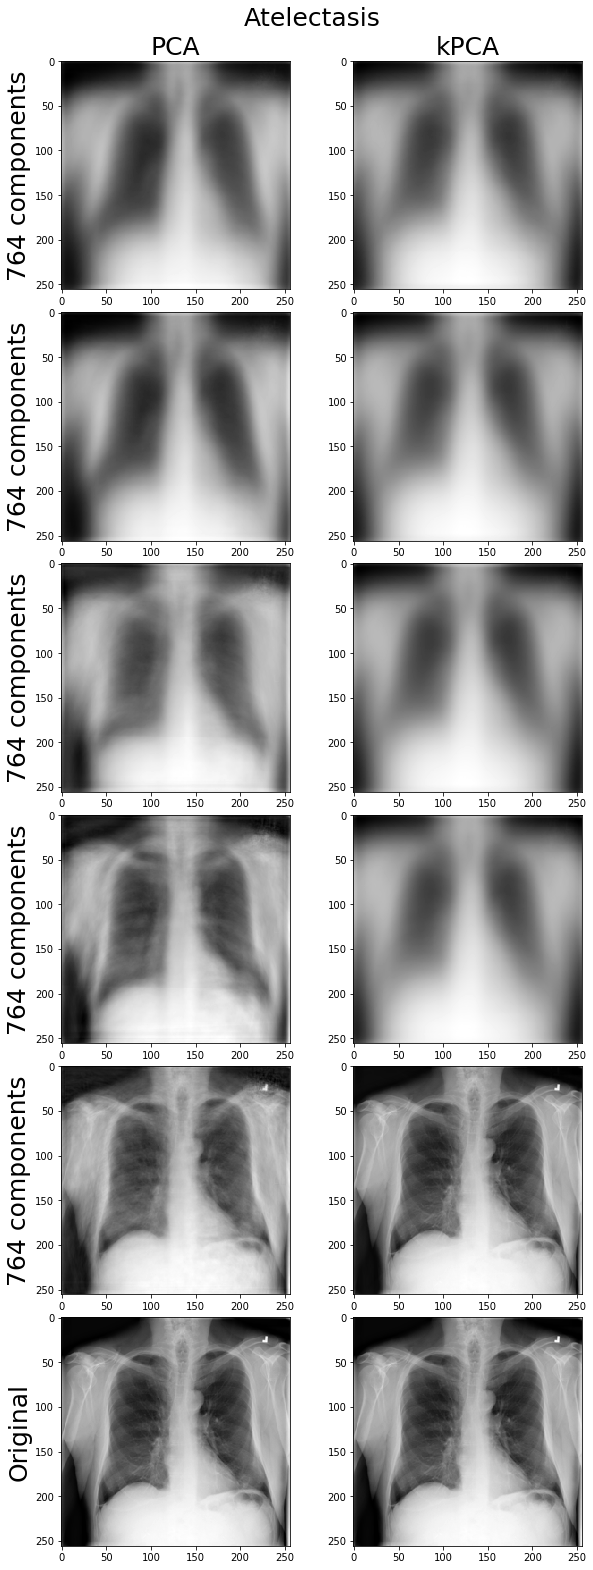

In [206]:
# compare by eye

def plot_func(im_index=0):
    orig_image = dat.iloc[indices[im_index]].values.reshape((h,w))

    fig = plt.figure(figsize = (10,25))
    fig.suptitle(findings[im_index], size = 25)
    for axes_index in range(len(n_axes)):
        pca_im = combined_low_dim_reps[axes_index][im_index].reshape((h,w))
        kpca_im = kpca_combined_low_dim_reps[axes_index][im_index].reshape((h,w))
        # for pca
        ax = fig.add_subplot(len(n_axes)+1, 2, axes_index*2+1)
        ax.imshow(pca_im, cmap=plt.cm.gray)
        # for kpca
        ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax1 = fig.add_subplot(len(n_axes)+1, 2, axes_index*2+2)
        ax1.imshow(kpca_im, cmap=plt.cm.gray)
        if axes_index==0:
            ax.set_title('PCA',fontsize=25)
            ax1.set_title('kPCA',fontsize=25)
    for i in range(2):
        ax = fig.add_subplot(len(n_axes)+1, 2, 2*len(n_axes)+i+1)
        ax.imshow(orig_image, cmap=plt.cm.gray)
        if i == 0:
            ax.set_ylabel('Original', fontsize=25)
    fig.subplots_adjust(hspace=0.1, wspace=0.1, top=0.95)
    plt.show()

plot_func(0)

In [209]:
# now play around with interactive plots, I'm not sure how this will work if exported to html
from ipywidgets import widgets

widgets.interact(plot_func,im_index=(0,3,1))

<function __main__.plot_func(im_index=0)>

As we have already seen, the images reconstructed from kPCA are sometimes better than those reconstructed by PCA and sometimes worse.

#### Mean-Squared Error (MSE)
<a id="mse"></a>

Perhaps the simplest method for comparing two images is to subtract one image from the other, square the differences, sum the squares, then divide by the number of pixels. 

$$MSE = \frac{1}{mn} \sum_{i=0}^{m-1}\sum_{j=0}^{n-1}\left[ I_1(i,j) - I_2(i,j) \right] ^2$$

where $m$ and $n$ are the dimensions of the image. For us $I_1$ will be the original image and $I_2$ will be the reconstructed image from PCA or kPCA.

This is found at ```skimage.measure.compare_mse```

n_rows 5, n_cols 4


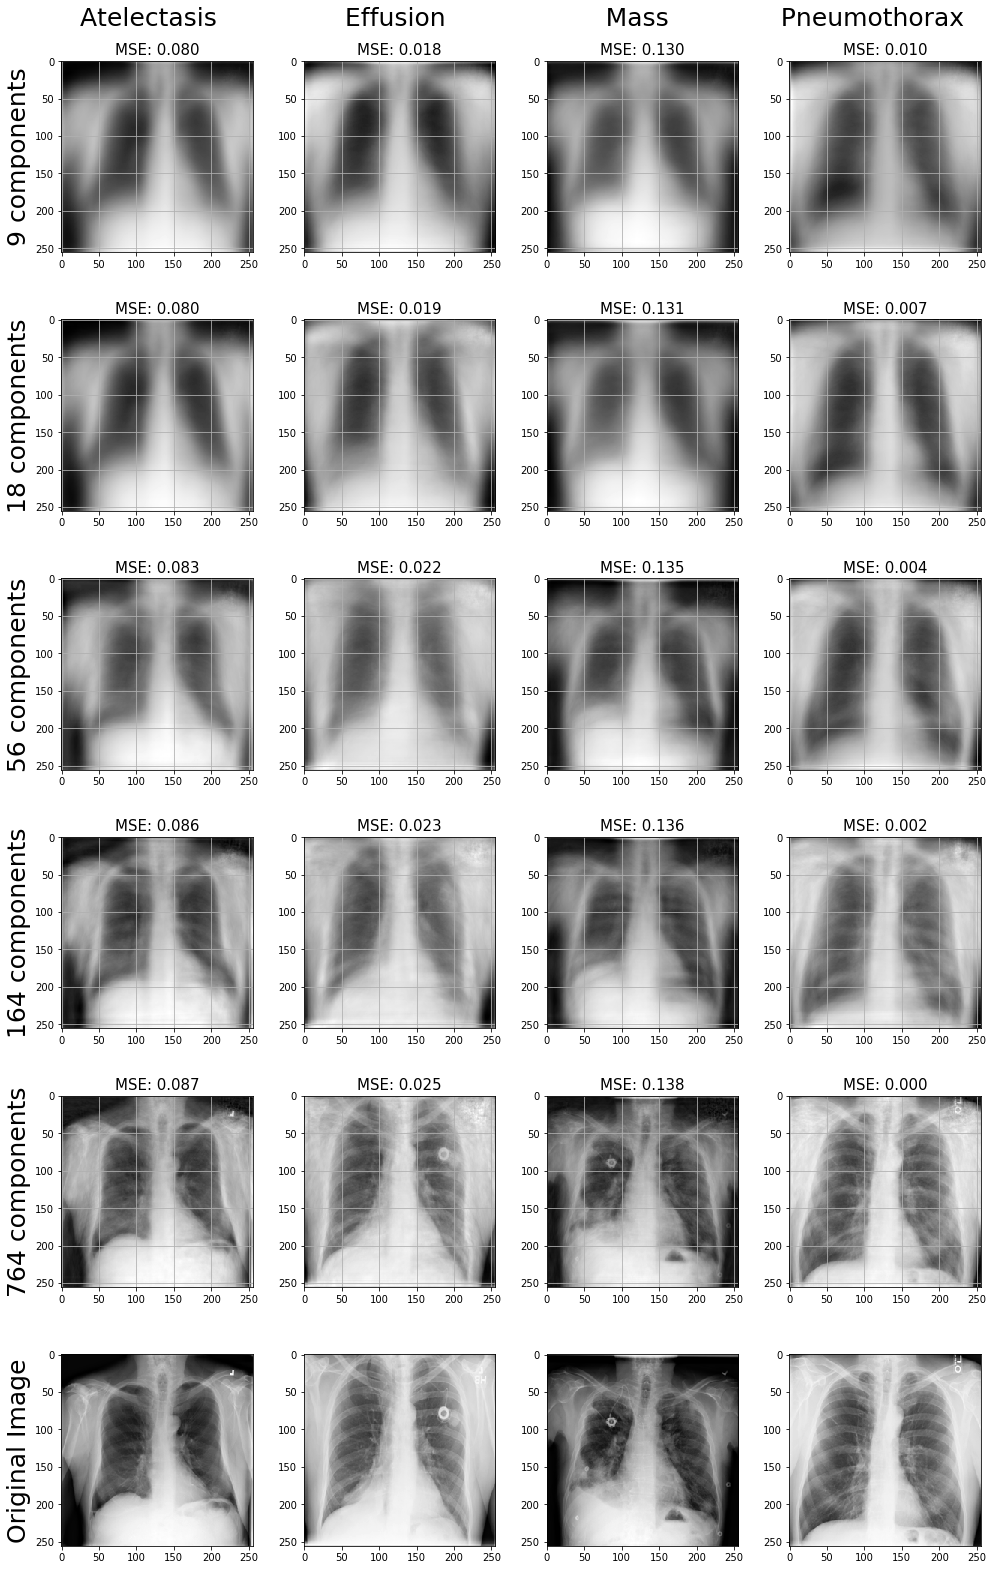

In [148]:
#mse
from skimage.measure import compare_mse

pca_mse = []
kpca_mse = []

# first loop over the images
for image_index in range(len(indices)):
    original_image = dat.iloc[indices[col_num]].values.reshape((h,w)).astype(np.float32)
    pca_list = []
    kpca_list = []
    # now loop over the number of axes
    for n_ax_index in range(len(n_axes)):
        pca_image = combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        kpca_image = kpca_combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        pca_list.append( compare_mse(original_image, pca_image) )
        kpca_list.append( compare_mse(original_image, kpca_image) )
    pca_mse.append(pca_list)
    kpca_mse.append(kpca_list)

# now just plot with the results
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
#honestly, there is bound to be a better way to do this, but this works
title_str = '    Atelectasis\t\t       Effusion\t\t           Mass\t             Pneumothorax'
fig.suptitle(title_str.expandtabs(), fontsize=25)
n_rows = len(n_axes)
print('n_rows {}, n_cols {}'.format(n_rows,n_cols))
for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax.set_title('MSE: {:.3f}'.format(pca_mse[col_num][row_num]), fontsize = 15)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(top=0.95, hspace=0.35, wspace=0.1)
plt.show()

We can see that the mean squared error is not likely a good way to compare the difference of images.

#### Normalized Root Mean-Squared Error (NRMSE)
<a id="nrmse"></a>

While [Mean Squared Error](#mse) is okay, it can not be used to compare differences between multiple sets of images. To alleviate this issue, we can simply normalize the MSE. There are multiple ways to normalize the error. Some of the most common normalization schemes are Euclidian, min-max, and mean.

- Eulidian: the MSE is normalized by the averaged Euclidian norm of $I_1$ (the original "true" image)
$$NRMSE_{\rm{Euclidian}} = MSE \times \frac{\sqrt{mn}}{||I_1||_F}$$
where $||I_1||_F$ is the [Frobenius Norm](http://mathworld.wolfram.com/FrobeniusNorm.html)

- min-max: the MSE is normalized by the range of intensities of $I_1$
$$NRMSE_{\rm{min/max}} = MSE \times \frac{1}{\max{(I_1)}-\min{(I_1)}}$$

- mean: the MSE is normalized by the mean of $I_1$
$$NRMSE_{\rm{mean}} = MSE \times \frac{1}{\rm{mean}{(I_1)}}$$

4 5
n_rows 5, n_cols 4


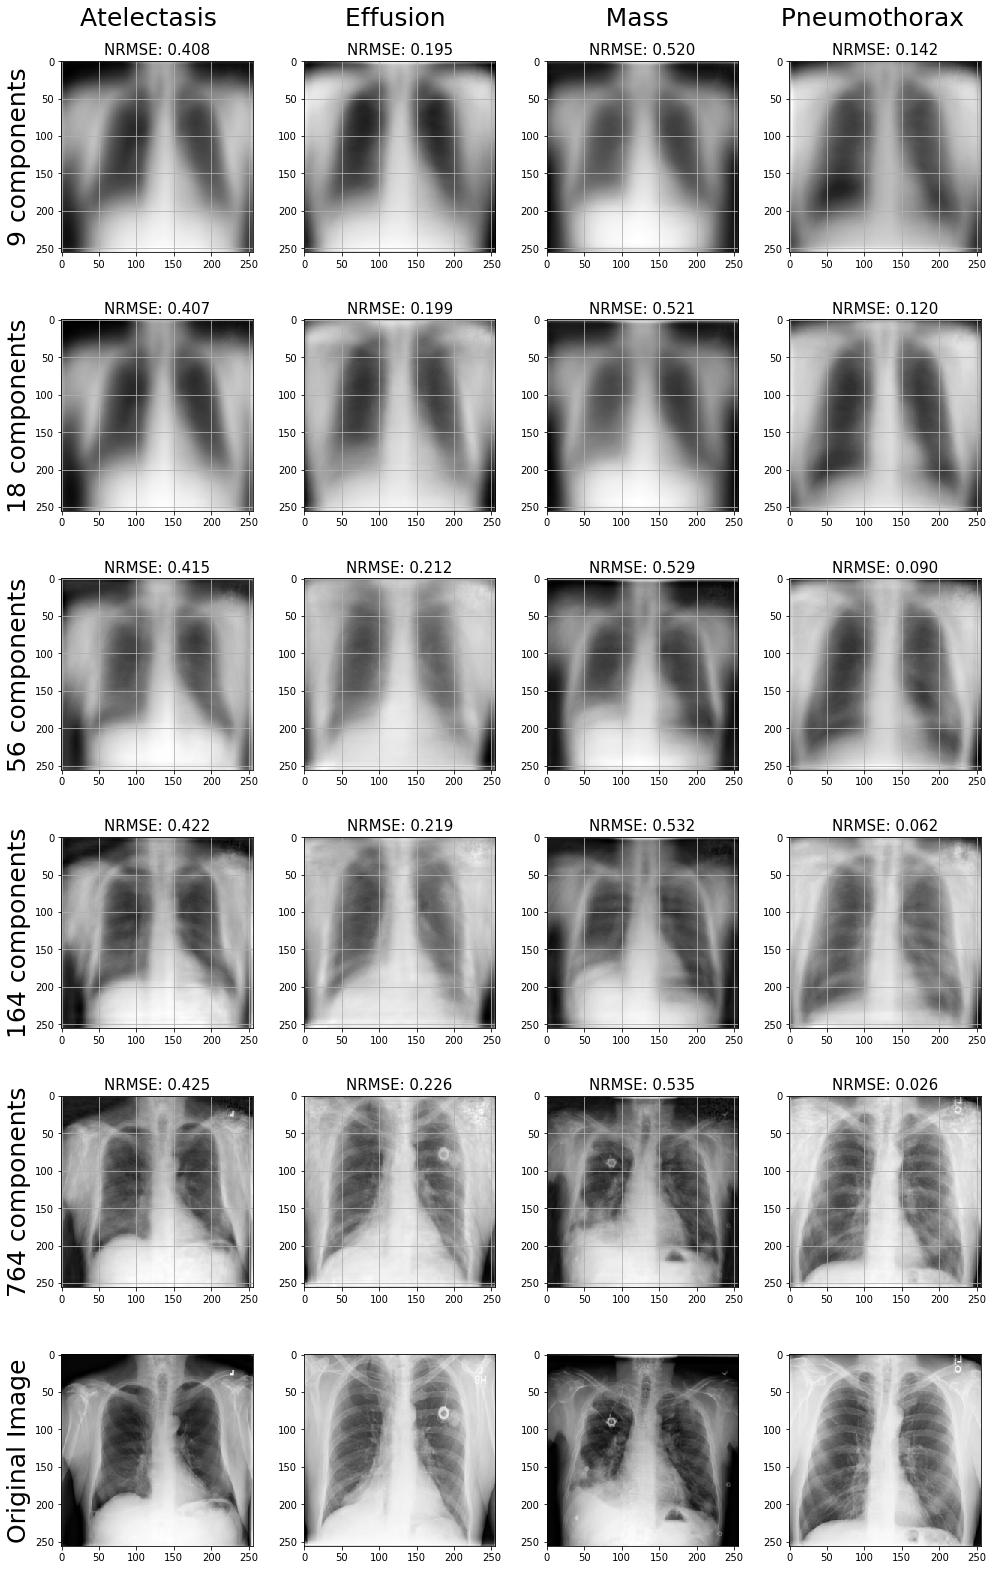

In [150]:
#nrmse
from skimage.measure import compare_nrmse

pca_nrmse = []
kpca_nrmse = []

# first loop over the images
for image_index in range(len(indices)):
    original_image = dat.iloc[indices[col_num]].values.reshape((h,w)).astype(np.float32)
    pca_list = []
    kpca_list = []
    # now loop over the number of axes
    for n_ax_index in range(len(n_axes)):
        pca_image = combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        kpca_image = kpca_combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        pca_list.append( compare_nrmse(original_image, pca_image, norm_type='Euclidean') )
        kpca_list.append( compare_nrmse(original_image, kpca_image, norm_type='Euclidean') )
    pca_nrmse.append(pca_list)
    kpca_nrmse.append(kpca_list)

print(len(pca_nrmse),len(pca_nrmse[0]))

# now just plot with the results
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
#honestly, there is bound to be a better way to do this, but this works
title_str = '    Atelectasis\t\t       Effusion\t\t           Mass\t             Pneumothorax'
fig.suptitle(title_str.expandtabs(), fontsize=25)
n_rows = len(n_axes)
print('n_rows {}, n_cols {}'.format(n_rows,n_cols))
for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax.set_title('NRMSE: {:.3f}'.format(pca_nrmse[col_num][row_num]), fontsize = 15)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(top=0.95, hspace=0.35, wspace=0.1)
plt.show()

We can see that the NRMSE is slightly better than the MSE, but it is still not a very consistent way to measure how close images are to each other.

#### Peak Signal to Noise Ratio (PSNR)
<a id="psnr"></a>

Another common metric used is the peak signal to noise ratio. This also builds off of the [Mean Squared Error](#mse). PSNR is defined as (in units of dV)

$$PSNR = 10 \times \log_{10} \left( \frac{\rm{MAX}^2{(I_1)}}{MSE} \right) $$

where $\rm{MAX}^2{(I_1)}$ is the maximum possible pixel value for the image which is not necessarily the maximum value actually present in the image.

4 5
n_rows 5, n_cols 4


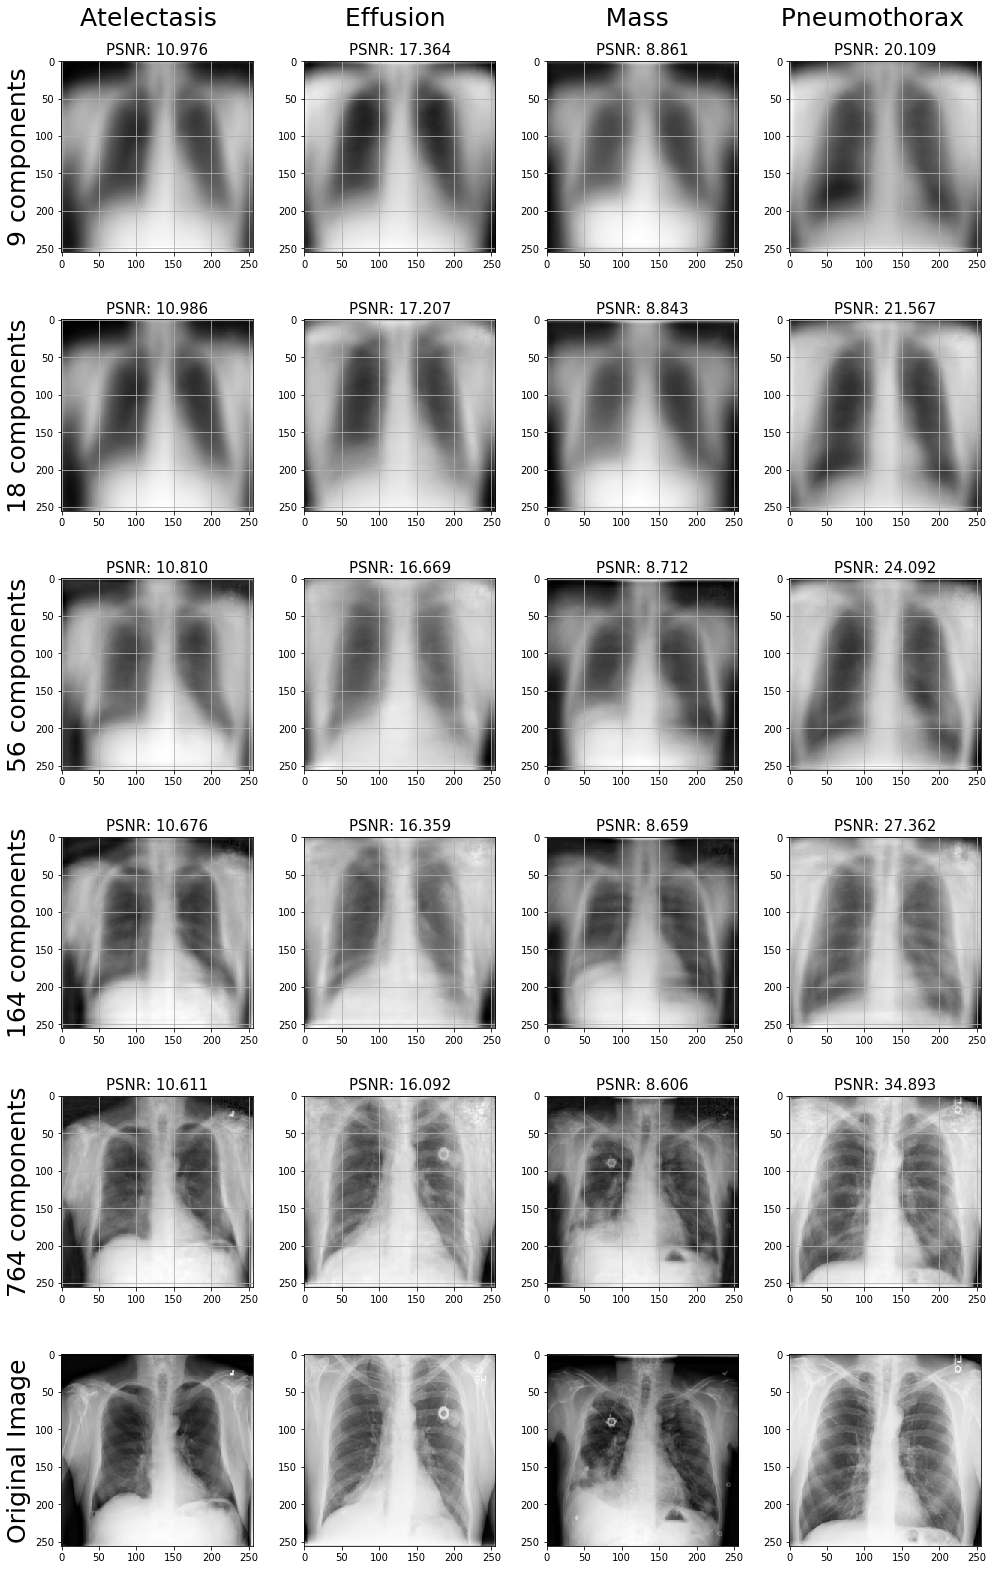

In [151]:
#psnr
from skimage.measure import compare_psnr

pca_psnr = []
kpca_psnr = []

# first loop over the images
for image_index in range(len(indices)):
    original_image = dat.iloc[indices[col_num]].values.reshape((h,w)).astype(np.float32)
    pca_list = []
    kpca_list = []
    # now loop over the number of axes
    for n_ax_index in range(len(n_axes)):
        pca_image = combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        kpca_image = kpca_combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        pca_list.append( compare_psnr(original_image, pca_image) )
        kpca_list.append( compare_psnr(original_image, kpca_image) )
    pca_psnr.append(pca_list)
    kpca_psnr.append(kpca_list)

print(len(pca_psnr),len(pca_psnr[0]))

# now just plot with the results
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
#honestly, there is bound to be a better way to do this, but this works
title_str = '    Atelectasis\t\t       Effusion\t\t           Mass\t             Pneumothorax'
fig.suptitle(title_str.expandtabs(), fontsize=25)
n_rows = len(n_axes)
print('n_rows {}, n_cols {}'.format(n_rows,n_cols))
for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax.set_title('PSNR: {:.3f}'.format(pca_psnr[col_num][row_num]), fontsize = 15)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(top=0.95, hspace=0.35, wspace=0.1)
plt.show()

We can see that PSNR is not a good way to measure these images. The results are possibly meaningful if we have multiple recronstructions of the same image, but it does not appear to be meaningful for comparing multiple original images.

#### Mean Structural Simularity Index (SSIM)
<a id="ssim"></a>

The final metric we will look at is the Structural Simularity Index. This method is a bit more complex than the previous methods considered. Basically, we will break the images into patches and compare the images patch by patch. Mathematically, we have

$$
\begin{align}
l(x,y) &= \frac{2\mu_x\mu_y+C_1}{\mu_x^2+\mu_y^2+C_1} \\
c(x,y) &= \frac{2\sigma_x\sigma_y+C_2}{\sigma_x^2+\sigma_y^2+C_2} \\
r(x,y) &= \frac{\sigma_{xy}+C_3}{\sigma_x\sigma_y+C_3}
\end{align}
$$

where 
- $C_1$, $C_2$, and $C_3$ are there to prevent instabilities when the various $\sigma$ or $\mu$ values are 0. 

- $l$ is related to the luminous differences

- $c$ is relaed to the contrast differences

- $r$ is related to the structure differences

Finally, the SSIM is

$$\rm{SSIM}(x,y) = \left[ l(x,y) \right] ^\alpha \times \left[ c(x,y) \right] ^\beta \times \left[ r(x,y) \right] ^\gamma $$

where $\alpha$, $\beta$, and $\gamma$ control the relative importance of each component. There have been many modifications to this basic metric including MS-SSIM, G_SSIM, and various 4 component SSIMs. However, we will stick with skimage's implementation for now.

4 5


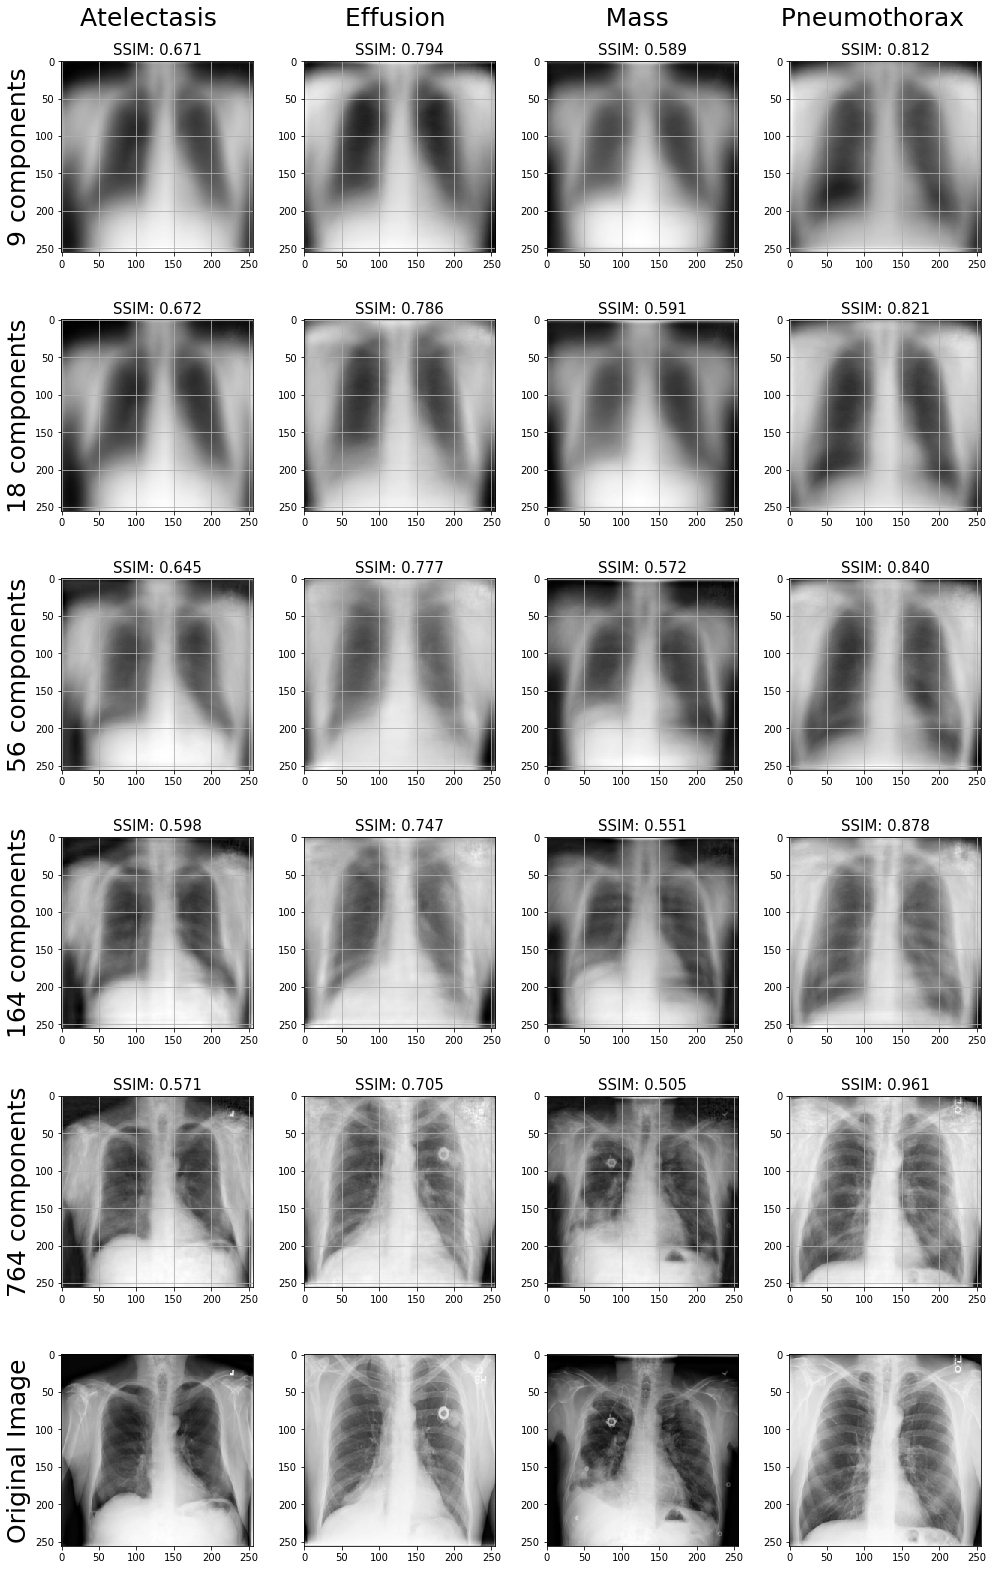

In [153]:
# now ssim
from skimage.measure import compare_ssim

pca_ssim = []
kpca_ssim = []

# first loop over the images
for image_index in range(len(indices)):
    original_image = dat.iloc[indices[col_num]].values.reshape((h,w)).astype(np.float32)
    pca_list = []
    kpca_list = []
    # now loop over the number of axes
    for n_ax_index in range(len(n_axes)):
        pca_image = combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        kpca_image = kpca_combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        pca_list.append( compare_ssim(original_image, pca_image) )
        kpca_list.append( compare_ssim(original_image, kpca_image) )
    pca_ssim.append(pca_list)
    kpca_ssim.append(kpca_list)

print(len(pca_ssim),len(pca_ssim[0]))

# now just plot with the results
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
#honestly, there is bound to be a better way to do this, but this works
title_str = '    Atelectasis\t\t       Effusion\t\t           Mass\t             Pneumothorax'
fig.suptitle(title_str.expandtabs(), fontsize=25)
n_rows = len(n_axes)

for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax.set_title('SSIM: {:.3f}'.format(pca_ssim[col_num][row_num]), fontsize = 15)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(top=0.95, hspace=0.35, wspace=0.1)
plt.show()

We can see that SSIM performs better than the other methods, but it is still hard to compare representations from different original images. The results are still not completely scaled to make this comparison meaningful, but it seems to be the best so far.

### $L_P$ Norm
<a id="lp"></a>

As another idea, we can try taking different $L_P$ norms. Because all of our pixel values are between zero and one, squaring square of the difference of pixels (also between zero and one) will necessarily be smaller than the difference itself. We pick L$_{1}$ and L$_{1/2}$ norms because our images are gray scale. This means the pixel values are between zero and one, and therefore the absolute value of the difference between the pixels is also between zero and one. The square of this difference is necessarily smaller than the difference itself, which may be biasing our results. Also, the L$_1$ and L$_{1/2}$ norms are relativly common so they seem like an appropriate place to start.

4 5


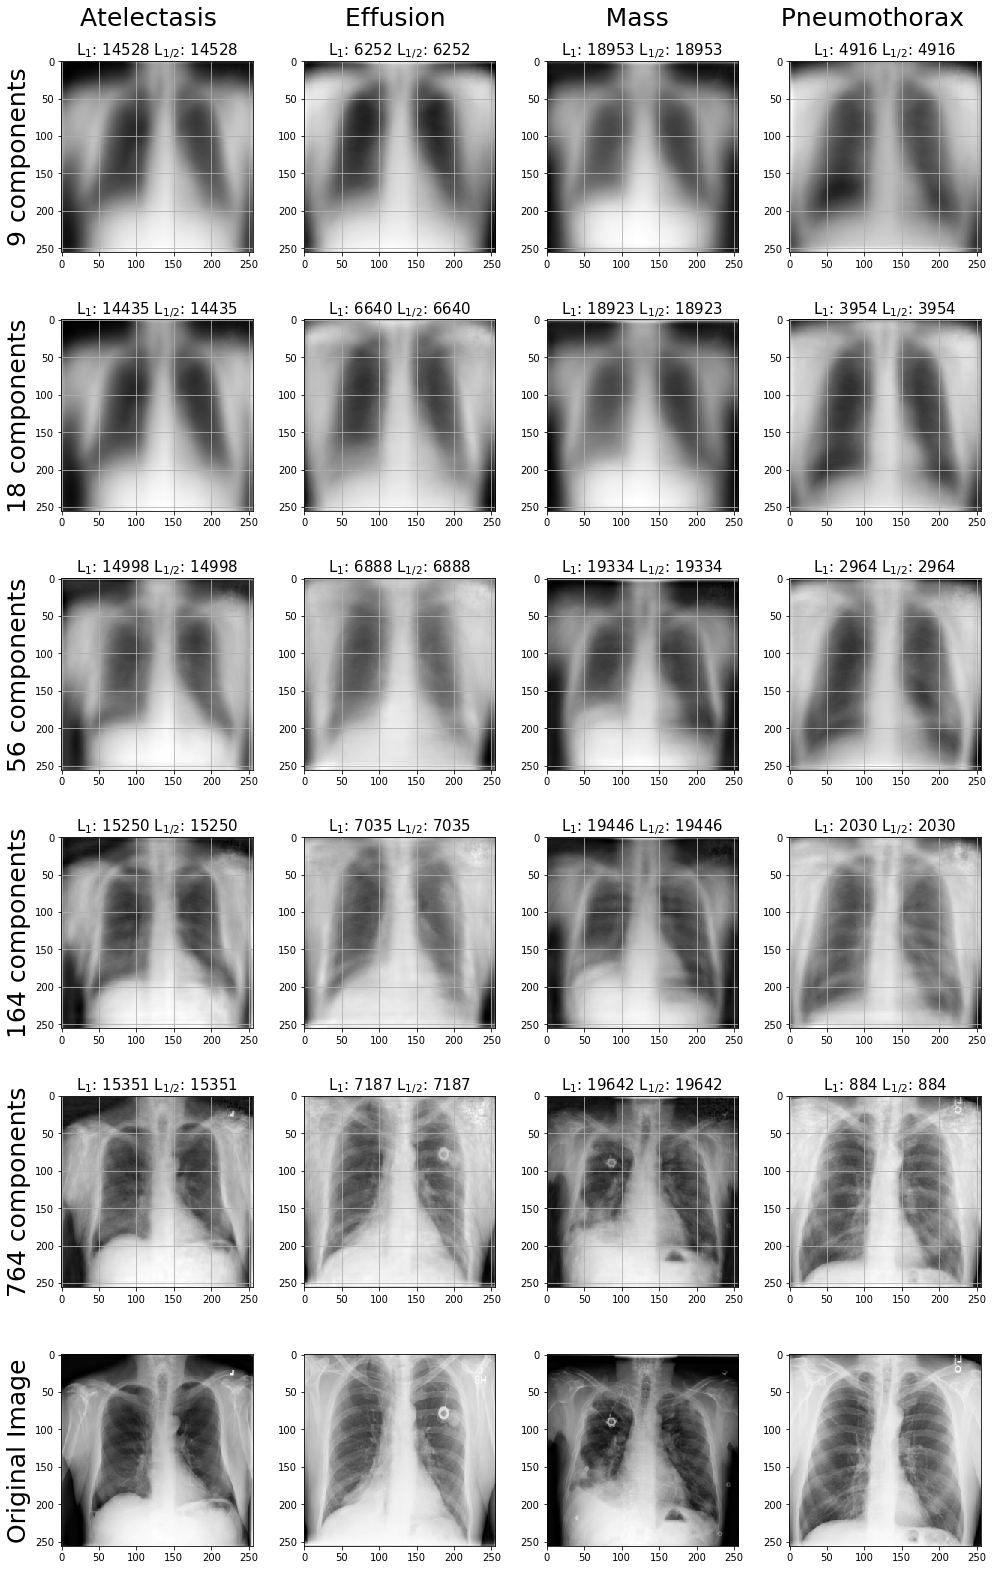

In [170]:
def Lp_norm(image_1, image_2, p = 2):
    norm = (np.sum((np.abs(image_1-image_2)))**p)**(1/p)
    return norm

pca_l1 = []
pca_l12 = []

# first loop over the images
for image_index in range(len(indices)):
    original_image = dat.iloc[indices[col_num]].values.reshape((h,w)).astype(np.float32)
    pca_list = []
    kpca_list = []
    # now loop over the number of axes
    for n_ax_index in range(len(n_axes)):
        pca_image = combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        kpca_image = kpca_combined_low_dim_reps[n_ax_index][image_index].reshape((h,w)).astype(np.float32)
        pca_list.append( Lp_norm(original_image, pca_image, p=1) )
        kpca_list.append( Lp_norm(original_image, kpca_image, p=0.5) )
    pca_l1.append(pca_list)
    pca_l12.append(kpca_list)

print(len(pca_ssim),len(pca_ssim[0]))

# now just plot with the results
fig = plt.figure(figsize=(17,25))
n_cols = len(indices)
findings = [gen_df_PA_single['Finding Labels'].iloc[indx] for indx in indices]
#honestly, there is bound to be a better way to do this, but this works
title_str = '    Atelectasis\t\t       Effusion\t\t           Mass\t             Pneumothorax'
fig.suptitle(title_str.expandtabs(), fontsize=25)
n_rows = len(n_axes)

for row_num in range(n_rows):
    low_dim_representation = combined_low_dim_reps[row_num]
    for col_num in range(n_cols):
        img_place = row_num*n_cols+col_num+1
        ax = fig.add_subplot(n_rows+1, n_cols, img_place)
        ax.imshow(low_dim_representation[col_num].reshape((h,w)), cmap=plt.cm.gray)
        if col_num == 0:
            ax.set_ylabel('{} components'.format(n_axes[row_num]), fontsize=25)
        ax.set_title(r'L$_{1}$: '+'{:.0f}'.format(pca_l1[col_num][row_num])+r' L$_{1/2}$: '+'{:.0f}'.format(pca_l1[col_num][row_num]),
                     fontsize = 15)
        ax.grid()

for col_num in range(n_cols):
    ax = fig.add_subplot(n_rows+1, n_cols, n_rows*n_cols+col_num+1)
    ax.imshow(dat.iloc[indices[col_num]].values.reshape((h,w)), cmap=plt.cm.gray)
    if col_num == 0:
        ax.set_ylabel('Original Image', fontsize=25)
    
fig.subplots_adjust(top=0.95, hspace=0.35, wspace=0.1)
plt.show()

We can see from the various methods above, that measuring the closeness of two images quantatively is difficult. Other studies on radiological images have resorted to somewhat exotic . [Renieblas _et. al._](https://www.ucm.es/data/cont/media/www/pag-88221/JMI-17059R_online.pdf) found

>4-MS-G-SSIM provides optimal results in all images and types of distortion. The second most effict IQM is 4-MS-G-r*.

### Feature Extraction
<a id="feature_extraction"></a>



In [6]:
from __future__ import print_function
import numpy as np
import PIL.Image as Image
import cv2
import pandas as pd
from skimage.filters import sobel_h, sobel_v
from skimage.feature import daisy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import seaborn as sns

In [7]:
file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
file_path_2 = '/users/jamesthomas/MachineLearning_Python/Lab2/'

df = pd.read_csv(file_path_2+'male_PA_single_disease.csv')
new_df = df[['Image Index','Finding Labels']]
new_df.groupby(['Finding Labels'])

#### Gabor filters feature extraction
<a id="gabor"></a>

In [8]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            

def compute_gabor(image_name, kernels):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(img, kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
    
    return feats.reshape(-1)

In [9]:
cnt = 0
gabor_stats = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    gabor_stats += [compute_gabor(image_name, kernels)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

99.8719590268886 % done! 566.152489s cost!


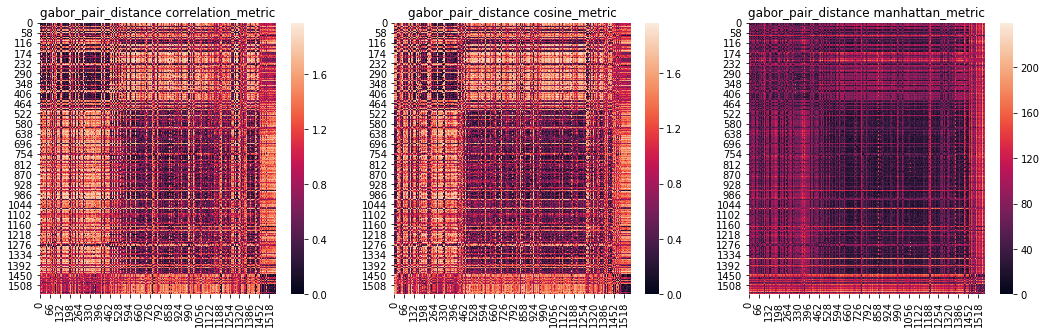

In [10]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

std = StandardScaler()


gabor_df = pd.DataFrame(np.array(gabor_stats))

gabor_pair_distance_1 = pairwise_distances(std.fit_transform(gabor_df.values), metric='correlation')
gabor_pair_distance_2 = pairwise_distances(std.fit_transform(gabor_df.values), metric='cosine')
gabor_pair_distance_3 = pairwise_distances(std.fit_transform(gabor_df.values), metric='manhattan')


fig = plt.figure(figsize = (18,5))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title('gabor_pair_distance correlation_metric')
sns.heatmap(gabor_pair_distance_1, annot=False, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('gabor_pair_distance cosine_metric')
sns.heatmap(gabor_pair_distance_2, annot=False, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('gabor_pair_distance manhattan_metric')
sns.heatmap(gabor_pair_distance_3, annot=False, ax=ax3)

plt.show()

In the heatmap, I'm using several metrics (correlation, cosine, manhattan), and the results are quite similar. Since the images are already grouped by label, we can see in the heatmap the largest block in the middle is for the label 'No Findings'. Hence, using gabor stats to classify if there is desease might be promising, and its clear that to differentiate desease types will not work on gabor stats.

#### Daisy Feature Extractor
<a id="daisy"></a>

CPU times: user 767 ms, sys: 48 ms, total: 815 ms
Wall time: 815 ms


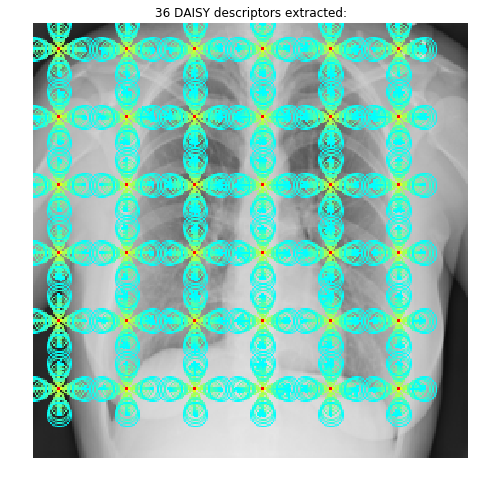

In [11]:
img = Image.open(file_path+'00005845_002.png')
%time descs, descs_img = daisy(img, visualize=True,step = 40,radius = 15, rings = 10,histograms = 4, orientations = 8)
descs_num = descs.shape[0] * descs.shape[1]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(descs_img)
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

In [12]:
def get_daisy_vec(image_name):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    descs, descs_img = daisy(img, visualize=True,step = 40,radius = 15, rings = 10,histograms = 4, orientations = 8)
    descs_num = descs.shape[0] * descs.shape[1]
    return np.reshape(descs,(descs_num,descs.shape[2]))

In [13]:
cnt = 0
daisy_vec_list = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    daisy_vec_list += [get_daisy_vec(image_name)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

99.8719590268886 % done! 1294.575488s cost!


In [14]:
# first one hot encode
def one_hot_encoder(df, col_name):
    one_hot = pd.get_dummies(df[col_name])
    df.drop(col_name, axis=1, inplace=True)
    return df.join(one_hot) # can we do .join with inplace=True

one_hot_cols = ['Finding Labels']
for name in one_hot_cols:
     one_hot_df= one_hot_encoder(new_df, name)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Key Point Matching
<a id="key_point_matching"></a>

Since daisy features are localized features, to calculate the distance between two images, we need to use a key point matching method. Although there are a few methods already implemented in OpenCV and SKlearn, I decided to build one myself. For any daisy feature in the first image, I loop over the daisy feature list of the second image and find the nearest one (based on Euclidean distance), then remove this featuren from the list of the second image and move on to the next feature of the first image. Since from this definition, the distance might not be symmetric, I define the actual distance to be the average of distance of image1 to image2 and image2 to image1.

In [15]:
def daisy_dist_one_way(daisy_vec_1,daisy_vec_2):
    dist = 0
    
    vec_list_1, vec_list_2 = [daisy_vec_1[i] for i in range(len(daisy_vec_1))],[daisy_vec_2[j] for j in range(len(daisy_vec_2))]
    for vec_1 in vec_list_1:
        tmpDist = np.linalg.norm(vec_1-vec_list_2[0])
        tmpVec = 0
        for k in range(len(vec_list_2)):
            if np.linalg.norm(vec_1-vec_list_2[k]) < tmpDist:
                tmpDist = np.linalg.norm(vec_1-vec_list_2[k])
                tmpVec = k
        vec_list_2.pop(tmpVec)
        dist += tmpDist
    return dist

def daisy_dist(daisy_vec_1,daisy_vec_2):
    daisy_vec_1 = np.reshape(daisy_vec_1,(36, 328))
    daisy_vec_2 = np.reshape(daisy_vec_2,(36, 328))
    return (daisy_dist_one_way(daisy_vec_1,daisy_vec_2)+daisy_dist_one_way(daisy_vec_2,daisy_vec_1))/2

Based on the distance defined above, we can employ KNN method to build a classifier.

In [16]:
daisy_vec_list = [vec.reshape(-1) for vec in daisy_vec_list]
X,y = np.array(daisy_vec_list), one_hot_df['No Finding'].values
Idx = np.arange(len(X))
np.random.shuffle(Idx)

idx, idx_test = Idx[:1400], Idx[1400:]

x_sample = X[idx]
y_sample = y[idx]

In [17]:

from sklearn.neighbors import KNeighborsClassifier
nbrs = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric=daisy_dist)

%time nbrs.fit(x_sample,y_sample)

CPU times: user 1min 2s, sys: 325 ms, total: 1min 2s
Wall time: 1min 2s


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
           metric=<function daisy_dist at 0x7fffd212c510>,
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [18]:
%time nbrs.predict([X[99]])

CPU times: user 11 s, sys: 134 ms, total: 11.1 s
Wall time: 11 s


array([0], dtype=uint8)

So here the training takes around 1 min. However, each prediction takes around 11 seconds. Since we need to build multiple classifiers, this will take a long time. The reason is that when we use KNN to predict, we need to calculate the distance of the test data to all training data. And in our pairwisely defined distance, it costs a long time. To solve this problem, I'll precalculate the distance between all data points, and save it in a two dimensional list. Then when I train the data or make a prediction, I can load from the existing list. Since the KNN classifier is based on the distance between the vectors, and the classifier for different labels are all using the same vectors, loading the distances from the list will save a lot of time.

In [ ]:
# this one takes a long time
dist_list = [[0 for i in range(len(X))] for j in range(len(X))]
cnt = 0
start_time = time.time()
for i in range(len(X)):
    for j in range(len(X)):
        if i == j:
            dist_list[i][j] = 0
        else:
            if dist_list[j][i] != 0:
                dist_list[i][j] = dist_list[j][i]
            else:
                dist_list[i][j] = daisy_dist(X[i],X[j])
        cnt += 1
        if cnt % 500 == 0:
            clear_output()
            print('{} % done! {:2f}s cost!'.format((cnt/len(X)/len(X))*100,time.time()-start_time))

In [ ]:
def get_dist(i,j):
    return dist_list[int(i[0])][int(j[0])]

In [ ]:
sample_size = 1500
Idx = np.arange(len(one_hot_df))
np.random.shuffle(Idx)

idx, idx_test = Idx[:sample_size], Idx[sample_size:]
desease_types = list(one_hot_df)[1:]

In [ ]:
from sklearn.metrics import f1_score

def KNN(desease_type):
    y = one_hot_df[desease_type].values
    y_sample = y[idx]
    y_test = y[idx_test]

    from sklearn.neighbors import KNeighborsClassifier
    nbrs_precalculated_dist = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree', metric=get_dist, weights = 'distance')

    nbrs_precalculated_dist.fit([[val] for val in idx],y_sample)
    x_test = nbrs_precalculated_dist.predict([[val] for val in idx_test])
    print('Accuracy for {} is {:.2f}'.format(desease_type,sum([1 if y_test[i]== x_test[i] else 0 for i in range(len(x_test))]) / len(x_test)))
    print('F1 score for {} is {:.2f}\n'.format(desease_type,f1_score(y_test, x_test)))
    
    return x_test

In [ ]:
daisy_knn_accruacy = [KNN(desease_type) for desease_type in desease_types]

#### FFT feature classifier
<a id="fft"></a>

The image and it's Fourier transformation have an one-to-one correspondance. While matching two original images requires key point matching, the Fourier transformed image is invariant under rotation and translation, thus we can use the Euclidean distance directly. As we can see from the images shown above, the difference between labels lies in the fine detail of the lung, which means the high frequency part of the image is more important than the low frequency part. I'm going to take more sample points from the high frequency part to represent the image, then build a KNN classifier based on this.

In [ ]:
from scipy import fftpack
im_fft = fftpack.fft2(img)

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

keep_fraction = 0.0625
im_fft2 = im_fft.copy()
r, c = im_fft2.shape
for s in range(4):
    im_fft2[int(s*r*keep_fraction*4):int((s*4+3-0.3*s)*r*keep_fraction)] = 0
    im_fft2[:, int(s*c*keep_fraction*4):int((s*4+3-0.3*s)*c*keep_fraction)] = 0

fig = plt.figure(figsize = (18,5))

ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Original image')
plt.imshow(img, plt.cm.gray)


ax2 = fig.add_subplot(1,4,2)
ax2.set_title('Fourier transform')
plot_spectrum(im_fft)

ax3 = fig.add_subplot(1,4,3)
ax3.set_title('Filtered Spectrum')
plot_spectrum(im_fft2)

im_new = fftpack.ifft2(im_fft2).real
ax3 = fig.add_subplot(1,4,4)
ax3.set_title('Reconstructed Image')
plt.imshow(im_new, plt.cm.gray)

In [ ]:
def fft_filtered(image_name):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = Image.open(file_path+image_name)
    im_fft = fftpack.fft2(img)
    keep_fraction = 0.0625
    im_fft2 = im_fft.copy()
    r, c = im_fft2.shape
    for s in range(4):
        im_fft2[int(s*r*keep_fraction*4):int((s*4+3-0.3*s)*r*keep_fraction)] = 0
        im_fft2[:, int(s*c*keep_fraction*4):int((s*4+3-0.3*s)*c*keep_fraction)] = 0
    fft_vec = im_fft2.reshape(-1)
    fft_vec = fft_vec[np.nonzero(fft_vec)]
    return np.concatenate((fft_vec.real, fft_vec.imag), axis=None)

In [ ]:
cnt = 0
fft_vec_list = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    fft_vec_list += [fft_filtered(image_name)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

In [ ]:
X_fft = np.array(fft_vec_list)
Idx_fft = np.arange(len(X_fft))
np.random.shuffle(Idx_fft)
idx_fft, idx_test_fft = Idx_fft[:1400], Idx_fft[1400:]

x_sample_fft = X_fft[idx_fft]
x_test_fft = X_fft[idx_test_fft]

In [ ]:
def KNN_fft(desease_type):
    y_fft = one_hot_df[desease_type].values
    y_sample_fft = y_fft[idx_fft]
    y_test_fft = y_fft[idx_test_fft]

    nbrs_fft = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree',weights = 'distance')

    nbrs_fft.fit(x_sample_fft,y_sample_fft) 
    x_predict_fft = nbrs_fft.predict(x_test_fft)
    accuracy = sum([1 if y_test_fft[i] == x_predict_fft[i] else 0 for i in range(len(x_predict_fft))]) / len(x_predict_fft)
    print('Accuracy for {} is {:2f}'.format(desease_type,accuracy))
    print('F1 score for {} is {:.2f}\n'.format(desease_type,f1_score(y_test_fft, x_predict_fft)))
    return accuracy

In [ ]:
fft_knn_accruacy = [KNN_fft(desease_type) for desease_type in desease_types]

Gabor stats KNN

Here is a KNN classifier based on the gabor stats, which we had high expectation on the 'No Finding' label.

In [ ]:
X_gabor = np.array(gabor_stats)
Idx_gabor = np.arange(len(X_gabor))
np.random.shuffle(Idx_gabor)
idx_gabor, idx_test_gabor = Idx_gabor[:1400], Idx_gabor[1400:]

x_sample_gabor = X_gabor[idx_gabor]
x_test_gabor = X_gabor[idx_test_gabor]

In [ ]:
def KNN_gabor(desease_type):
    y_gabor = one_hot_df[desease_type].values
    y_sample_gabor = y_gabor[idx_gabor]
    y_test_gabor = y_gabor[idx_test_gabor]

    nbrs_gabor = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree',weights = 'distance')

    nbrs_gabor.fit(x_sample_gabor,y_sample_gabor) 
    x_predict_gabor = nbrs_gabor.predict(x_test_gabor)
    accuracy = sum([1 if y_test_gabor[i] == x_predict_gabor[i] else 0 for i in range(len(x_predict_gabor))]) / len(x_predict_gabor)
    print('Accuracy for {} is {:2f}'.format(desease_type,accuracy))
    print('F1 score for {} is {:.2f}\n'.format(desease_type,f1_score(y_test_gabor, x_predict_gabor)))
    return accuracy

In [ ]:
gabor_knn_accruacy = [KNN_gabor(desease_type) for desease_type in desease_types]

In [ ]:
['Percent for {} in test data is {:2f}'.format(desease_type,
                                               max(sum(one_hot_df[desease_type].values[idx_test_gabor])/len(idx_test_gabor),
                                                   1-sum(one_hot_df[desease_type].values[idx_test_gabor])/len(idx_test_gabor))) 
                                         for desease_type in desease_types]

In [ ]:
from sklearn import svm

def svm_gabor(desease_type):
    y_gabor = one_hot_df[desease_type].values
    y_sample_gabor = y_gabor[idx_gabor]
    y_test_gabor = y_gabor[idx_test_gabor]

    clf = svm.SVC(gamma=0.001, C=1.0)

    clf.fit(x_sample_gabor,y_sample_gabor) 
    x_predict_gabor = clf.predict(x_test_gabor)
    accuracy = sum([1 if y_test_gabor[i] == x_predict_gabor[i] else 0 for i in range(len(x_predict_gabor))]) / len(x_predict_gabor)
    print('Accuracy for {} is {:2f}'.format(desease_type,accuracy))
    print('F1 score for {} is {:.2f}\n'.format(desease_type,f1_score(y_test_gabor, x_predict_gabor)))
    return accuracy

In [ ]:
gabor_svm_accruacy = [svm_gabor(desease_type) for desease_type in desease_types]

### Prediction Promise
<a id="prediction_promise"></a>

As we can see from the previous methods. These methods (Daisy, FFT, and Gabor) do not do better than simply guessing according to the percentage each disease is present in the original data set. That is, we have not done better than rolling a die. Therefore, we will need additional methods do analyze the images for prediction. This is likely because the difference in the images between diseases is due to the fine structure of the images. This means all of the images are quite similar and classification will be difficult.

Based on the heatmap, we belive the classifier should give us a better prediction for gabor statistics. This indicates that we may need to use a different method to classify the images.

## Exceptional Work (__10 points total__)
<a id="exceptional_work"></a>

> $\cdot$ you have free reign to provide any additional analyses.<br>
$\cdot$ One idea (__required for 7000 level students__): perform feature extraction upon the images using a feature extractor that requires key point matching (such as SIFT/SURF/ORB or others). Then build a nearest neighbor classifier using a method appropriate for your chose features. you will need to investigate appropriate methods for comparisons with your chosen feature extraction technique. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive).<br>

We implemented this work when considering Daisy feature extraction and KNN, which can be seen [here](#key_point_matching). We also used ORB and KNN to predict below.

### ORB
<a id="orb"></a>

In [ ]:
import numpy as np
import cv2 as cv

img1 = cv.imread(file_path+df['Image Index'][5],0)
img2 = cv.imread(file_path+df['Image Index'][1],0)

lowe_ratio = 0.92

finder = cv.ORB_create()

kp1, des1 = finder.detectAndCompute(img1,None)
kp2, des2 = finder.detectAndCompute(img2,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good = []

for m,n in matches:
    if m.distance < lowe_ratio*n.distance:
        good.append([m])

msg1 = 'using %s with lowe_ratio %.2f' % ('orb', lowe_ratio)
msg2 = 'there are %d good matches' % (len(good))

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good, None, flags=2)

font = cv.FONT_HERSHEY_SIMPLEX
cv.putText(img3,msg1,(10, 250), font, 0.5,(255,255,255),1,cv.LINE_AA)
cv.putText(img3,msg2,(10, 270), font, 0.5,(255,255,255),1,cv.LINE_AA)
print(msg1,msg2)
plt.imshow(img3),plt.show()

From the image above we can see that ORB only captures the structure of the lung instead of the fine details associated with the disease inside of the lung. Due to this, we do not expect ORB to perform well.

In [ ]:
def get_orb_des(image_name):
    file_path = '/users/jamesthomas/MachineLearning_Python/Lab2/images/resize/thumb/'
    img = cv.imread(file_path+image_name,0)
    finder = cv.ORB_create()
    kp, des = finder.detectAndCompute(img,None)
    return des

cnt = 0
orb_list = []
start_time = time.time()
for image_name in new_df['Image Index'].values:
    orb_list += [get_orb_des(image_name)]
    cnt += 1
    if cnt % 10 == 0:
        clear_output()
        print('{} % done! {:2f}s cost!'.format(cnt/len(new_df['Image Index'].values)*100,time.time()-start_time))

In [ ]:
nanList = [1477,1508,1555,1450]

In [ ]:
def orb_matching_num(i,j):
    des1,des2 = orb_list[i], orb_list[j]
    lowe_ratio = 0.92
    if i in nanList or j in nanList:
        return 1
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good = []
    if not matches or len(matches[0]) <= 1:
        return 1
    for m,n in matches:
        if m.distance < lowe_ratio*n.distance:
            good.append([m])
    return len(good)
def orb_dist(i,j):
    i = int(i[0])
    j = int(j[0])
    return (orb_matching_num(i,i) + orb_matching_num(j,j) - orb_matching_num(i,j)*2)/(orb_matching_num(i,i) + orb_matching_num(j,j))

In the above cell we see that the number of des pf each image are different. To define the normalized distance , let Dist_{i,j} = (nbr1+nbr2-2$\times$nbr1,2)/(nbr1+nbr2) where nbr1 and nbr2 are the number of descriptors in each image and nbr12 is the number of matching descriptors shared by the images. According to this definition 0 < Dist_{i,j} < 1 and Dist{i,i} = 0.

In [ ]:
sample_size = 1500
Idx_orb = np.arange(len(one_hot_df))
np.random.shuffle(Idx_orb)

idx_orb, idx_test_orb = Idx_orb[:sample_size], Idx_orb[sample_size:]
desease_types = list(one_hot_df)[1:]

In [ ]:
def orb_KNN(desease_type):
    y_orb = one_hot_df[desease_type].values
    y_sample_orb = y_orb[idx_orb]
    y_test_orb = y_orb[idx_test_orb]

    from sklearn.neighbors import KNeighborsClassifier
    orb_knn = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree', metric=orb_dist, weights = 'distance')
    orb_knn.fit([[val] for val in idx_orb],y_sample_orb)
    x_test_orb = orb_knn.predict([[val] for val in idx_test_orb])
    print('Accuracy for {} is {:2f}'.format(desease_type,sum([1 if y_test_orb[i]== x_test_orb[i] else 0 for i in range(len(x_test_orb))]) / len(x_test_orb)))
    print('F1 score for {} is {:.2f}\n'.format(desease_type,f1_score(y_test_orb, x_test_orb)))
    return x_test_orb

In [ ]:
orb_knn_accruacy = [orb_KNN(desease_type) for desease_type in desease_types]

## Final Thoughts
<a id="thoughts"></a>

As we have seen, it is difficult to make accurate predictions based on the fine detail present in the x-ray images. To improve out methods we can try a few things.

- First, we can ask a doctor (or other medical professional) what sort of features we are specifically identifying to classify the images with specific diseases. This may allow us to focus on specific methods that will enhance these features.
- Second, deep learning may offer better predictions because it will use more features of the images where as our classifiers only extract a small subset of the features. There is no guarantee that the features we have extracted will accurately capture the information needed, especially in the case of medical images.

